# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import cv2


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print(device)

mps


# Data loading

In [2]:
# Custom Dataset that does LAB conversion on-the-fly
class CIFAR10ColorizationDataset(Dataset):
    def __init__(self):
        self.dataset = CIFAR10(root='./data', download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # img: [C, H, W] tensor

        # Convert to numpy
        img_np = img.permute(1,2,0).numpy()
        img_np = (img_np * 255).astype('uint8')

        # RGB to LAB
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        l_channel = lab[:,:,0] / 255.0
        ab_channels = (lab[:,:,1:] - 128) / 128.0

        # Tensors
        l = torch.tensor(l_channel).unsqueeze(0).float()
        ab = torch.tensor(ab_channels).permute(2,0,1).float()

        return l, ab

# Create Dataset
colorization_dataset = CIFAR10ColorizationDataset()

# Create DataLoader
dataloader = DataLoader(colorization_dataset, batch_size=256, shuffle=True)

## Verify dataset

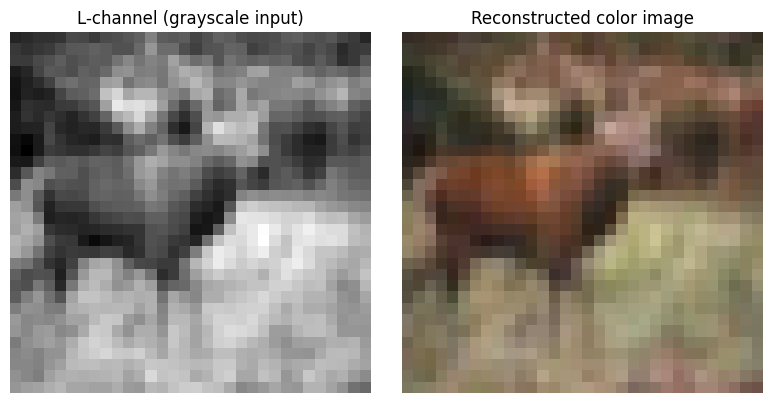

In [3]:
# Get one batch
l_batch, ab_batch = next(iter(dataloader))  # l_batch: [batch, 1, 128, 128], ab_batch: [batch, 2, 128, 128]

# Pick the first sample from batch
l = l_batch[0]    # [1, 128, 128]
ab = ab_batch[0]  # [2, 128, 128]

# Recover LAB image
l_img = (l.squeeze(0).numpy() * 255).astype('uint8')  # [128, 128], back to [0,255]
ab_img = (ab.permute(1,2,0).numpy() * 128) + 128      # [128, 128, 2], back to OpenCV LAB space

# Stack into LAB image
lab = np.zeros((32, 32, 3), dtype=np.uint8)
lab[:,:,0] = l_img
lab[:,:,1:] = ab_img.astype('uint8')

# Convert LAB -> RGB for viewing
rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(l_img, cmap='gray')
axes[0].set_title('L-channel (grayscale input)')
axes[0].axis('off')

axes[1].imshow(rgb)
axes[1].set_title('Reconstructed color image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Training

In [4]:
def train(model, optimizer, criterion, scheduler, num_epochs=10):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for l_batch, ab_batch in loop:
            l_batch = l_batch.to(device)
            ab_batch = ab_batch.to(device)

            output = model(l_batch)
            loss = criterion(output, ab_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

        # 🔵 Save the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint_filename = f"model_epoch_smoothl1_{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_filename)
            print(f"✅ Saved checkpoint at {checkpoint_filename}")

    return losses


# Encoder-Decoder Model

In [ ]:
class DeepColorizationCNN(nn.Module):
    def __init__(self):
        super(DeepColorizationCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(1), 
            nn.Conv2d(1, 64, kernel_size=3, padding=0),  # 1 -> 64 kernels
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2), 
            nn.MaxPool2d(2, 2),  # downsample
            nn.Dropout2d(0.2),

            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 128, kernel_size=3, padding=0),  # 64 -> 128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # downsample
            nn.Dropout2d(0.2),

            nn.ReflectionPad2d(2), 
            nn.Conv2d(128, 256, kernel_size=5, padding=0),  # 128 -> 256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(2), 
            nn.Conv2d(256, 256, kernel_size=5, padding=0),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2), # Reduced to 8x8 image
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # upsample
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(128, 128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # upsample
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.LeakyReLU(0.2),

            nn.ReflectionPad2d(1), 
            nn.Conv2d(64, 2, kernel_size=3, padding=0),  # output 2 channels (ab)
            nn.Tanh()  # normalized between [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Train encoder-decoder

In [ ]:
model = DeepColorizationCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

losses = train(model, optimizer, criterion)
# Plot the training losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Save progress
torch.save(model.state_dict(), "colorizer.pth")

In [ ]:
# Load model from file
model = DeepColorizationCNN().to(device)        # 1. recreate model
model.load_state_dict(torch.load("colorizer.pth"))  # 2. load weights
model.eval()      

## Encoder-Decoder Testing

In [ ]:

def recolor_image(model, filepath):
    model.eval()  # Set model to evaluation mode

    # 1. Load and preprocess image
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = img[:, :, 0]  # [H, W]

    orig_shape = l_channel.shape  # Save shape for later

    # Normalize L
    l = l_channel / 255.0
    l = torch.tensor(l).unsqueeze(0).unsqueeze(0).float().to(device)  # [1, 1, H, W]

    # 2. Feed through model
    with torch.no_grad():
        pred_ab = model(l)  # [1, 2, H, W]
        pred_ab = pred_ab.squeeze(0).cpu()  # [2, H, W]

    # 3. Postprocess
    pred_ab = pred_ab.permute(1, 2, 0).numpy()  # [H, W, 2]
    pred_ab = (pred_ab * 128) + 128  # Denormalize back to OpenCV format

    # Denormalize L back to [0, 255]
    l_channel = l_channel.astype(np.uint8)

    # Stack L and ab back together
    lab = np.zeros((orig_shape[0], orig_shape[1], 3), dtype=np.uint8)
    lab[:, :, 0] = l_channel
    lab[:, :, 1:] = pred_ab.astype(np.uint8)

    # Convert LAB to BGR (for OpenCV display)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return bgr

In [ ]:
# List of image filenames (without needing to repeat code)
image_names = ["horse.jpg", "dog.jpg", "deer.jpg", "ship.jpg"]

# Prepare a list to hold (original, grayscale, recolored) for each image
images = []

for name in image_names:
    img = cv2.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    colorized = recolor_image(model, name)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    colorized_rgb = cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB)
    
    images.append((img_rgb, gray, colorized_rgb))  # save tuple

# Now plot
fig, axes = plt.subplots(4, 3, figsize=(5, 4))  # (4 rows, 3 cols)

for i in range(4):  # for each image
    # Original
    axes[i, 0].imshow(images[i][0])
    axes[i, 0].set_title(f'Original {image_names[i][:-4].capitalize()}')
    axes[i, 0].axis('off')
    
    # Grayscale
    axes[i, 1].imshow(images[i][1], cmap='gray')
    axes[i, 1].set_title(f'Grayscale {image_names[i][:-4].capitalize()}')
    axes[i, 1].axis('off')
    
    # Recolored
    axes[i, 2].imshow(images[i][2])
    axes[i, 2].set_title(f'Recolored {image_names[i][:-4].capitalize()}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


# U-Net Architecture

In [5]:
class DeepColorizationUNet(nn.Module):
    def __init__(self):
        super(DeepColorizationUNet, self).__init__()

        # ------- Encoder ---------
        self.enc1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 64, 3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.enc3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.enc4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )

        # ------- Bottleneck ---------
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(1024, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        # ------- Decoder ---------
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1024, 512, 3),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        # Final 1x1 Conv to predict ab channels
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)
        self.final_activation = nn.Tanh()

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Bottleneck
        b = self.bottleneck(e4)

        # Decoder with skips
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final output
        out = self.final_conv(d1)
        out = self.final_activation(out)

        return out

## Train UNet

In [ ]:
'''
model = DeepColorizationUNet().to(device) 
model.load_state_dict(torch.load("model_epoch_60.pth"))
model.train()
'''

In [6]:
model = DeepColorizationUNet().to(device) 

In [7]:
from torch.optim.lr_scheduler import OneCycleLR

#model = DeepColorizationUNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,               # Peak learning rate
    steps_per_epoch=len(dataloader),
    epochs=60,
    pct_start=0.3,              # % of total steps to warmup (30% up, 70% down)
    anneal_strategy='cos'       # How to decay: 'cos' (cosine) or 'linear'
)
criterion = nn.SmoothL1Loss()

losses = train(model, optimizer, criterion, scheduler, num_epochs=60)

plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Epoch 1/60:   4%|▎         | 7/196 [00:04<02:09,  1.46it/s, loss=0.527]


KeyboardInterrupt: 

## Test U-Net

In [ ]:
# List of image filenames (without needing to repeat code)
image_names = ["horse.jpg", "dog.jpg", "apple.jpg", "ship.jpg"]

# Prepare a list to hold (original, grayscale, recolored) for each image
images = []

for name in image_names:
    img = cv2.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    colorized = recolor_image(model, name)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    colorized_rgb = cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB)
    
    images.append((img_rgb, gray, colorized_rgb))  # save tuple

# Now plot
fig, axes = plt.subplots(4, 3, figsize=(5, 4))  # (4 rows, 3 cols)

for i in range(4):  # for each image
    # Original
    axes[i, 0].imshow(images[i][0])
    axes[i, 0].set_title(f'Original {image_names[i][:-4].capitalize()}')
    axes[i, 0].axis('off')
    
    # Grayscale
    axes[i, 1].imshow(images[i][1], cmap='gray')
    axes[i, 1].set_title(f'Grayscale {image_names[i][:-4].capitalize()}')
    axes[i, 1].axis('off')
    
    # Recolored
    axes[i, 2].imshow(images[i][2])
    axes[i, 2].set_title(f'Recolored {image_names[i][:-4].capitalize()}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


### Save random image

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

# 1. Define a simple transform (load as tensor)
transform = transforms.ToTensor()

# 2. Load CIFAR-10 training set
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 3. Pick a random index
idx = random.randint(0, len(dataset) - 1)

# 4. Get the image and label
img_tensor, label = dataset[idx]

# 5. Save the image

# Make a folder if it doesn't exist
os.makedirs('saved_images', exist_ok=True)

# Turn tensor back to a grid (remove batch dimension)
# vutils.save_image expects a mini-batch, so we unsqueeze to [1, C, H, W]
vutils.save_image(img_tensor, f'saved_images/random_cifar10.jpg')

print(f"Saved random CIFAR-10 image with label: {dataset.classes[label]} ✅")